In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
import random

In [ ]:
import pandas as pd

ids = pd.read_csv('/content/drive/MyDrive/DL-LinkNet/train and test ids.csv')
path = '/content/drive/MyDrive/DL-LinkNet/Images'
img_list_X_train = []
img_list_X_test = []
for i in ids['train_ids']:
    img_list_X_train.append(os.path.join(path,'crop_row_' + str(i).zfill(3) + '.jpg'))
for i in ids['test_ids']:
    if not np.isnan(i):
        img_list_X_test.append(os.path.join(path,'crop_row_' + str(int(i)).zfill(3) + '.jpg'))

In [ ]:
img_width = 320
img_height = 240
img_channels = 3
number_of_init_filters = 16

In [ ]:
X_train = np.zeros((len(img_list_X_train), img_height, img_width, img_channels), dtype=np.int32)
for i, img_path in enumerate(img_list_X_train):
    # read image
    img_train = imread(img_path)
    X_train[i] = img_train

In [ ]:
X_train[0]

array([[[148, 150, 128],
        [160, 167, 133],
        [146, 160, 111],
        ...,
        [141, 163, 117],
        [149, 171, 124],
        [145, 169, 119]],

       [[138, 151, 107],
        [141, 157, 110],
        [136, 154, 104],
        ...,
        [143, 164, 121],
        [150, 172, 126],
        [154, 173, 127]],

       [[137, 154, 102],
        [138, 154, 107],
        [143, 159, 114],
        ...,
        [158, 184, 136],
        [157, 179, 130],
        [150, 170, 121]],

       ...,

       [[ 69,  62,  52],
        [ 86,  83,  68],
        [120, 118, 103],
        ...,
        [133, 126, 107],
        [151, 145, 123],
        [146, 140, 118]],

       [[107, 101,  87],
        [153, 151, 139],
        [111, 111, 101],
        ...,
        [135, 130, 108],
        [132, 127, 107],
        [134, 127, 108]],

       [[128, 122, 108],
        [102,  99,  92],
        [ 70,  70,  68],
        ...,
        [146, 144, 123],
        [127, 122, 103],
        [105,  97,  84]]

In [ ]:
train_output_path1 = '/content/drive/MyDrive/DL-LinkNet/train_labels'
img_list_y_train = []
for i in ids['train_ids']:
      img_list_y_train.append(os.path.join(train_output_path1,'crop_row_' + str(i).zfill(3) + '.npy'))
y_train = np.zeros((len(img_list_y_train), img_height, img_width, 1), dtype=bool)
for i, img_path in enumerate(img_list_y_train):
    # read image
    img_train = np.load(img_path)
    img_train = img_train[:, :, 0]
    img_train = np.expand_dims(img_train, axis=2)
    y_train[i] = img_train

In [ ]:
y_train[0].shape

(240, 320, 1)

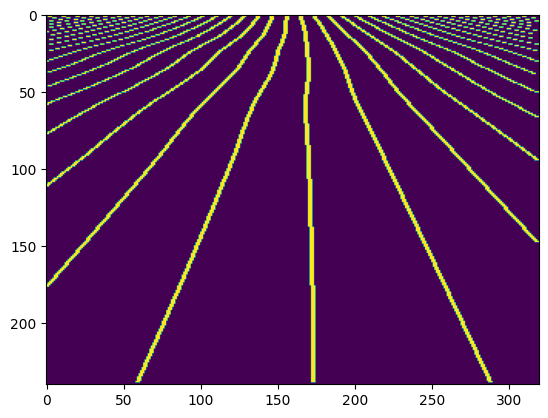

In [ ]:
plt.imshow(y_train[0])

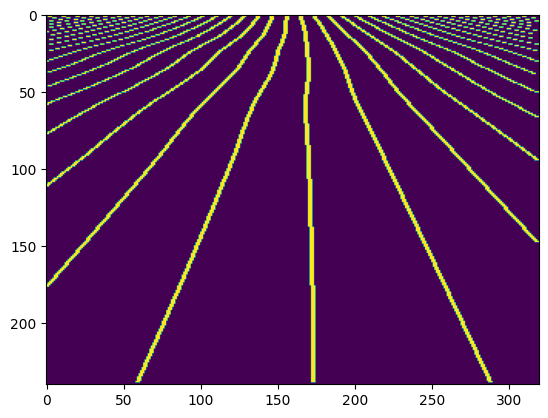

In [ ]:
plt.imshow(y_train[0])

In [ ]:
X_test = np.zeros((len(img_list_X_test), img_height, img_width, img_channels), dtype=np.int32)
for i, img_path in enumerate(img_list_X_test):
    # read image
    img_test = imread(img_path)
    X_test[i] = img_test

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization

def linknet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    # Decoder
    up6 = Concatenate()([UpSampling2D((2, 2))(conv5), conv4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Concatenate()([UpSampling2D((2, 2))(conv6), conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Concatenate()([UpSampling2D((2, 2))(conv7), conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu',padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Concatenate()([UpSampling2D((2, 2))(conv8), conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)



    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model



# Define the input shape and number of classes
input_shape = (img_height, img_width, img_channels)
num_classes = 2

# Create an instance of the LinkNet model
model = linknet(input_shape, num_classes)

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=4, epochs=20, callbacks=[early_stop])

model.save('model.h5')


Epoch 1/20
48/48 [==============================] - 35s 269ms/step - loss: 6.8856 - sparse_categorical_accuracy: 0.8971 - val_loss: 0.2313 - val_sparse_categorical_accuracy: 0.9347
Epoch 2/20
48/48 [==============================] - 10s 212ms/step - loss: 0.2330 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.2181 - val_sparse_categorical_accuracy: 0.9347
Epoch 3/20
48/48 [==============================] - 11s 220ms/step - loss: 0.2213 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.2230 - val_sparse_categorical_accuracy: 0.9348
Epoch 4/20
48/48 [==============================] - 11s 222ms/step - loss: 0.2222 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.2069 - val_sparse_categorical_accuracy: 0.9347
Epoch 5/20
48/48 [==============================] - 11s 225ms/step - loss: 0.2160 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.2013 - val_sparse_categorical_accuracy: 0.9350
Epoch 6/20
48/48 [==============================] - 11s 228ms/step - loss: 0.2010 - sparse_cate

In [ ]:
# Convert the predictions to a numpy array and transpose the dimensions
predictions = model.predict(X_test)
predictions = predictions.transpose(0, 3, 1, 2)

# Threshold the probability map to obtain a binary mask
binary_mask = torch.where(torch.from_numpy(predictions[:, 1]) > 0.4, torch.tensor(1), torch.tensor(0))

# Convert the binary mask to a grayscale image
grayscale_image = (binary_mask * 255).numpy().astype('int32')


3/3 [==============================] - 1s 511ms/step


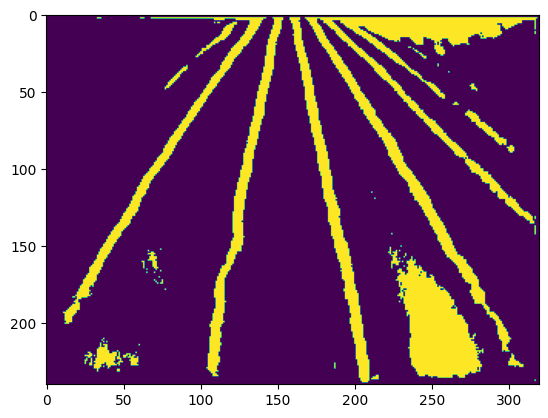

In [ ]:
plt.imshow(grayscale_image[9])

In [ ]:
import cv2
pred = grayscale_image[3]
cv2.imwrite("Image1.jpg", pred)

True

In [ ]:
img_list_X_test[3]

'/content/drive/MyDrive/DL-LinkNet/Images/crop_row_244.jpg'

In [ ]:
rles = []

for i in range(grayscale_image.shape[0]):
    id = img_list_X_test[i][16:19]
    rle = encode_mask_to_rle(grayscale_image[i])
    rles.append(rle)

df = pd.DataFrame({'ids': [img_list_X_test[i][50:53]  for i in range(grayscale_image.shape[0])], 'labels': rles})

In [ ]:
img_list_X_test[0][50:53]

'162'

In [ ]:
df.to_csv('Balaswamy_Rusum_3.csv', index=False)

In [ ]:
plt.imshow(resize(grayscale_image[3], (240,240,1)))

In [ ]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask
    255 - mask
    0 - background
    Returns encoded run length
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    return ' '.join(str(x) for x in runs)


def decode_rle_to_mask(rle, height = 240, width = 320):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask
    width : width of the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width))
    color = 255
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1])] = color

    return mask.reshape(height, width)